# ControlNet

In [ ]:
!pip install accelerate

In [ ]:
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xformers 0.0.25.post1 requires torch==2.2.2, but you have torch 2.2.1 which is incompatible.


In [ ]:
!git clone https://github.com/huggingface/diffusers
%pip install git+https://github.com/huggingface/diffusers
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

Cloning into 'diffusers'...
remote: Enumerating objects: 60617, done.
remote: Counting objects: 100% (615/615), done.
remote: Compressing objects: 100% (383/383), done.
remote: Total 60617 (delta 379), reused 361 (delta 201), pack-reused 60002
Receiving objects: 100% (60617/60617), 41.98 MiB | 11.61 MiB/s, done.
Resolving deltas: 100% (44083/44083), done.
  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-0j1t6z_l
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-0j1t6z_l
  Resolved https://github.com/huggingface/diffusers to commit b833d0fc80900525a1e3b4df10422cc4283c4a55
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.28.0.dev0-py3-none-any.whl size=2094210 sha256=7bc54ca578d6b8a5cc79ec91a907a1a4b6759e499e53b552b592d1bf45e4bfa6
  Stored in directory: /tmp/pip-ep

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image
from PIL import Image

# Load an image from a local file in the /birme directory
image_path = "/content/drive/MyDrive/birme/IMG_2430 2.webp"  # Update 'your_image_name.jpg' with the actual file name
image = Image.open(image_path)


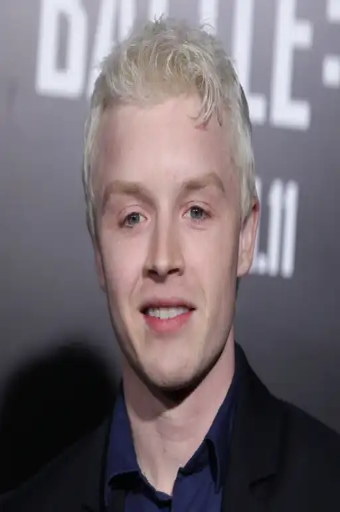

In [ ]:
size = (340, 512)
image = image.resize(size)
image

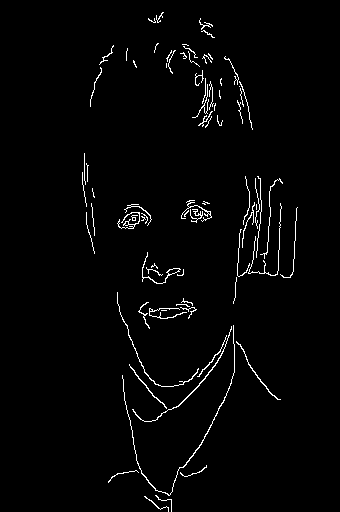

In [ ]:
import cv2
from PIL import Image
import numpy as np

image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image

In [ ]:

from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch


controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny",
                                             torch_dtype=torch.float16).to("cuda")

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float16).to("cuda")

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
from diffusers import UniPCMultistepScheduler

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

In [ ]:
pipe.enable_model_cpu_offload()

In [ ]:
pipe.enable_xformers_memory_efficient_attention()

  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


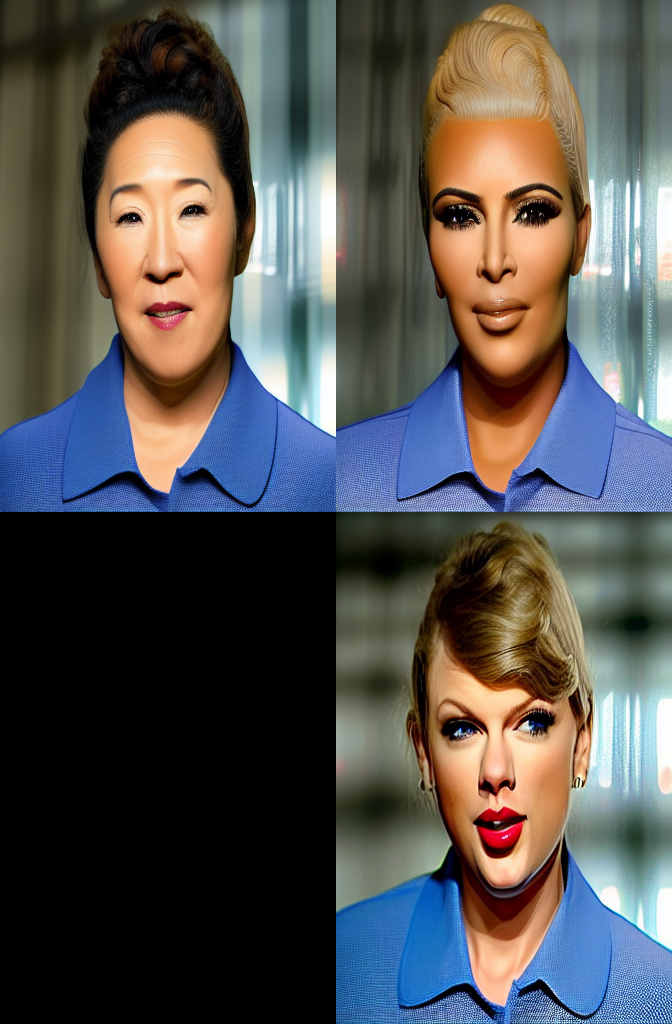

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

prompt = ", best quality, extremely detailed, 4k, hdr, super resolution"
prompt = [t + prompt for t in ["Sandra Oh", "Noel Fisher", "rihanna", "taylor swift"]]
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(len(prompt))]

output = pipe(
    prompt,
    canny_image,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * len(prompt),
    generator=generator,
    num_inference_steps=20,
)

image_grid(output.images, 2, 2)